In [ ]:
# Import the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import scikitplot as skplt
from xgboost import plot_tree
import xgboost
import multiprocessing
import graphviz
import pydotplus
from IPython.display import Image
from io import StringIO

In [ ]:
# Load the data
url = "https://drive.google.com/file/d/1nirICzuv5k0tMzX0rE4CBRIkL19LdBXL/view?usp=sharing"
reconstructed_url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(reconstructed_url)
df.head()
feature_cols = ['fixed acidity', 'volatile acidity', 'citirc acid', 'residual sugar', 'chlorides', 'free sulfer dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

In [ ]:
# Examine Data for Consistency
df.info

<bound method DataFrame.info of       fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4             0.700         0.00             1.9      0.076   
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1594            6.2             0.600         0.08             2.0      0.090   
1595            5.9             0.550         0.10             2.2      0.062   
1596            6.3             0.510         0.13             2.3      0.076   
1597            5.9             0.645         0.12             2.0      0.075   
1598            6.0             0.310         0.47             3.6      0.067

In [ ]:
# Check for null values and missing data
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [ ]:
# Examine attritbutes and target variables

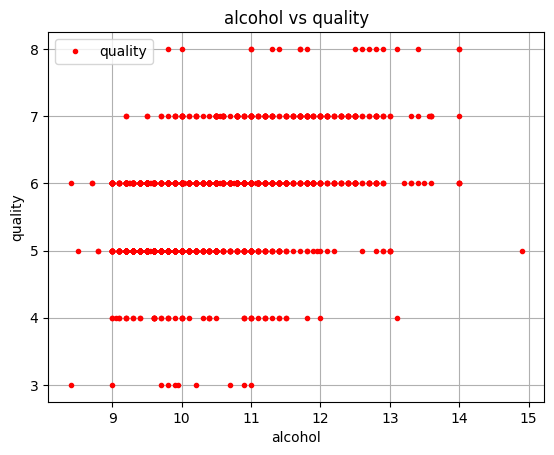

In [ ]:
# Plot various graphs to find quality of wine
df.plot(x='alcohol',y='quality',style='.',color='r')
plt.title('alcohol vs quality')
plt.xlabel('alcohol')
plt.ylabel('quality')
plt.grid()
plt.show()

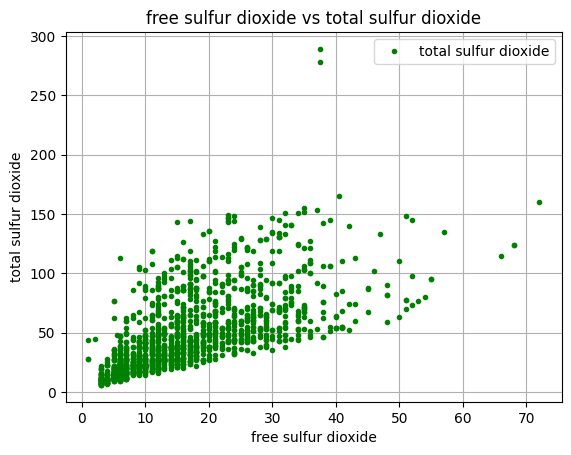

In [ ]:
df.plot(x='free sulfur dioxide',y='total sulfur dioxide', style='.',color='g')
plt.title('free sulfur dioxide vs total sulfur dioxide')
plt.xlabel('free sulfur dioxide')
plt.ylabel('total sulfur dioxide')
plt.grid()
plt.show()

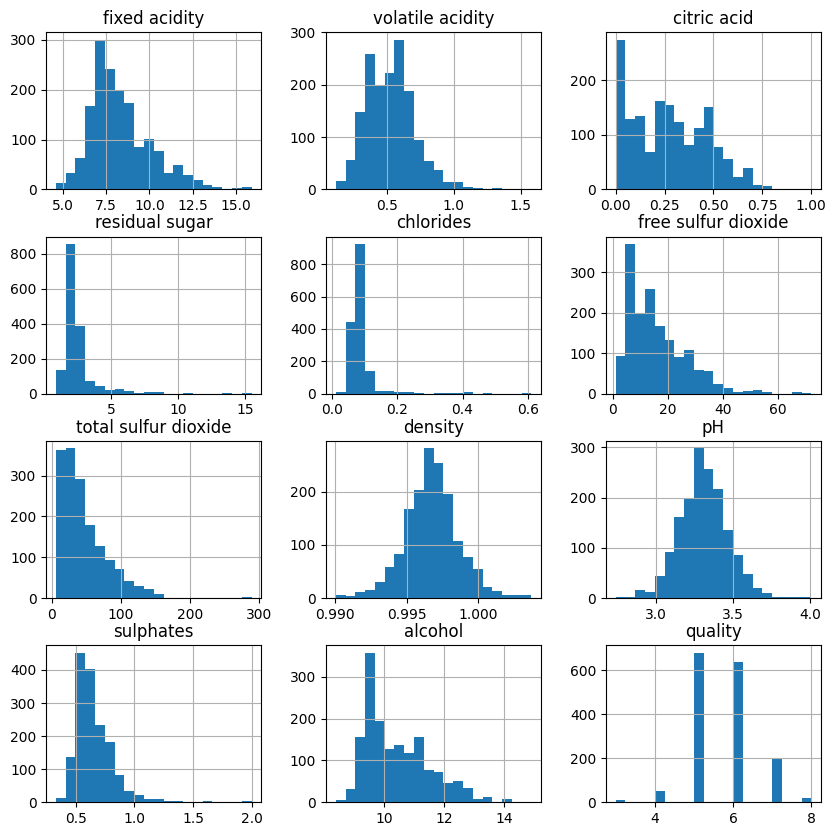

In [ ]:
# Data is easily scattered on features
df.hist(bins=20, figsize=(10, 10))
plt.show()

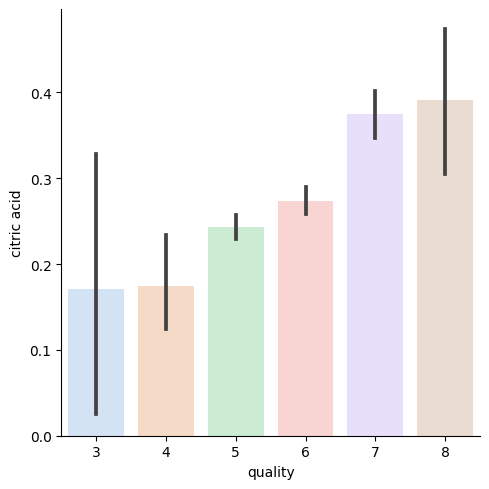

In [ ]:
# Checking which value of citric acid can make changes in quality
sns.catplot(data=df, kind="bar",x="quality",y="citric acid",palette="pastel",alpha=.5, height=5)

<Axes: xlabel='quality', ylabel='citric acid'>

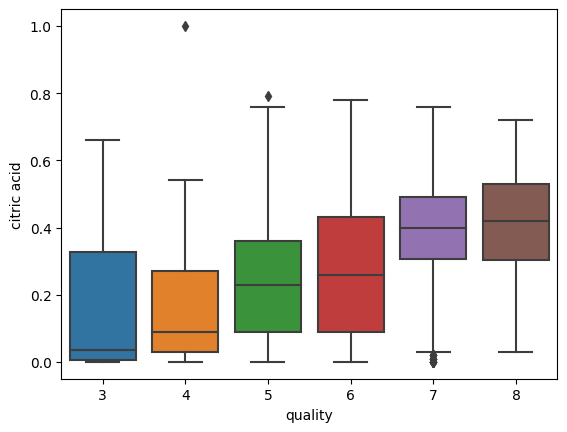

In [ ]:
sns.boxplot(x="quality",y="citric acid",data=df)

<Axes: xlabel='quality', ylabel='fixed acidity'>

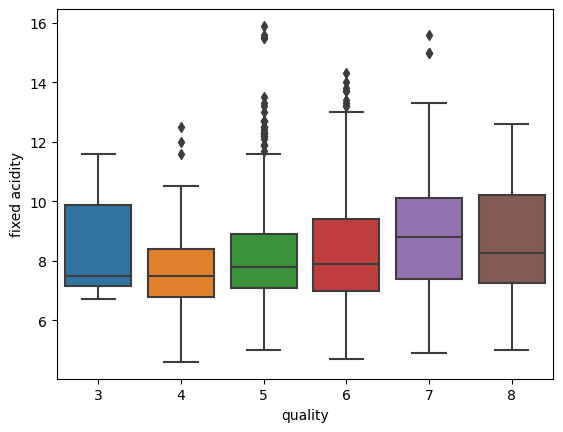

In [ ]:
sns.boxplot(x="quality",y="fixed acidity",data=df)

<Axes: >

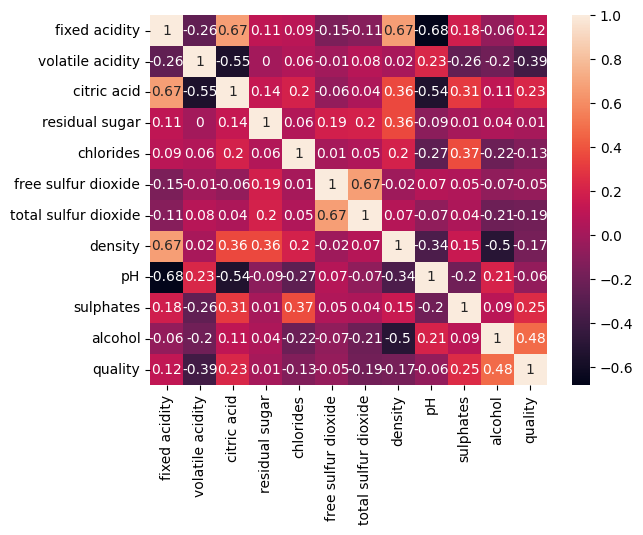

In [ ]:
# Observe correlation matrix
correlation_matrix = df.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)

In [ ]:
# Define X and Y
df['winequality']=[1 if x>=6 else 0 for x in df['quality']]
X=df.drop(['quality','winequality'],axis = 1)
y=df['winequality']
y_distinct = y.unique()
n = y.shape[0]

# separate the data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Scale the data
mm = MinMaxScaler()
fit=mm.fit(X_train)
X_train=fit.transform(X_train)
X_test=fit.transform(X_test)

In [ ]:
# Hyperparameter Tuning for Decision Tree Classifier
dt_pipe = Pipeline([('mms', MinMaxScaler()),
                     ('dt', DecisionTreeClassifier())])
params = [{'dt__max_depth': range(1,10),
           'dt__max_features': range(1,10),
           'dt__min_samples_leaf': range(1,5),
           'dt__criterion': ['gini', 'entropy']}]

gs_dt = GridSearchCV(dt_pipe,
                      param_grid=params,
                      scoring='accuracy',
                      cv=5,
                      verbose = 3,
                      n_jobs = -1)
gs_dt.fit(X, y)
print(gs_dt.best_params_)
# find best model score
print(gs_dt.score(X, y))

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
{'dt__criterion': 'gini', 'dt__max_depth': 5, 'dt__max_features': 4, 'dt__min_samples_leaf': 2}
0.7648530331457161


In [ ]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 2, criterion = 'gini', max_features = 4)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

y_probs = clf.predict_proba(X_test)

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
scores = cross_val_score(clf, X, y, cv=5)
print("Cross Validation Score: ",scores.mean())
print(classification_report(y_test, y_pred))

Accuracy: 0.746875
Cross Validation Score:  0.7160717084639497
              precision    recall  f1-score   support

           0       0.70      0.80      0.74       148
           1       0.80      0.70      0.75       172

    accuracy                           0.75       320
   macro avg       0.75      0.75      0.75       320
weighted avg       0.75      0.75      0.75       320



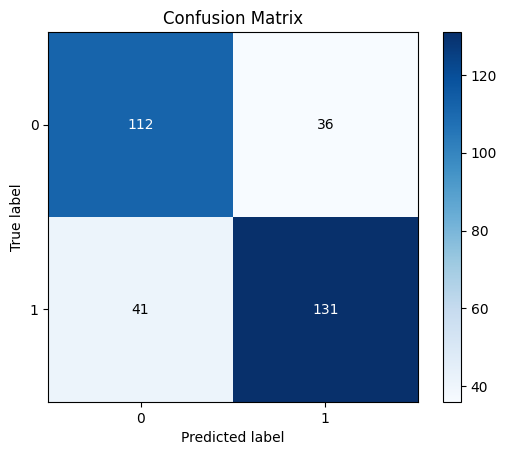

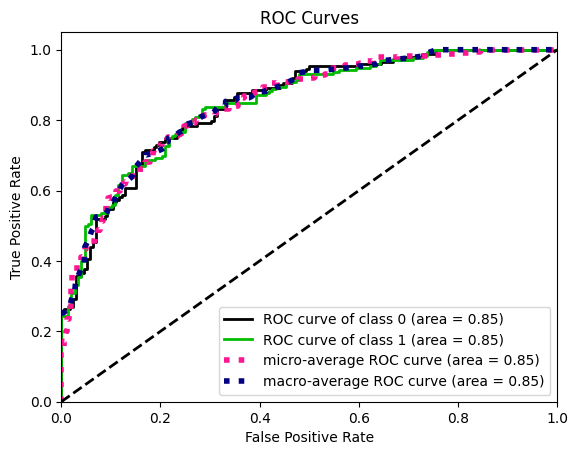

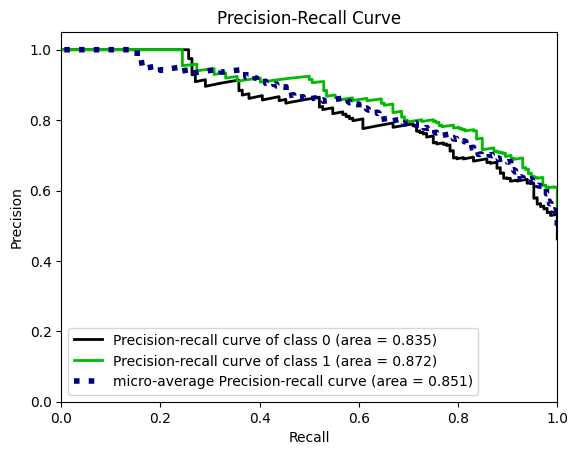

In [ ]:
# Confusion Matrix and graphs of the ROC and Precison-Recall curves
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
skplt.metrics.plot_roc(y_test, y_probs)
skplt.metrics.plot_precision_recall(y_test, y_probs)
plt.show()

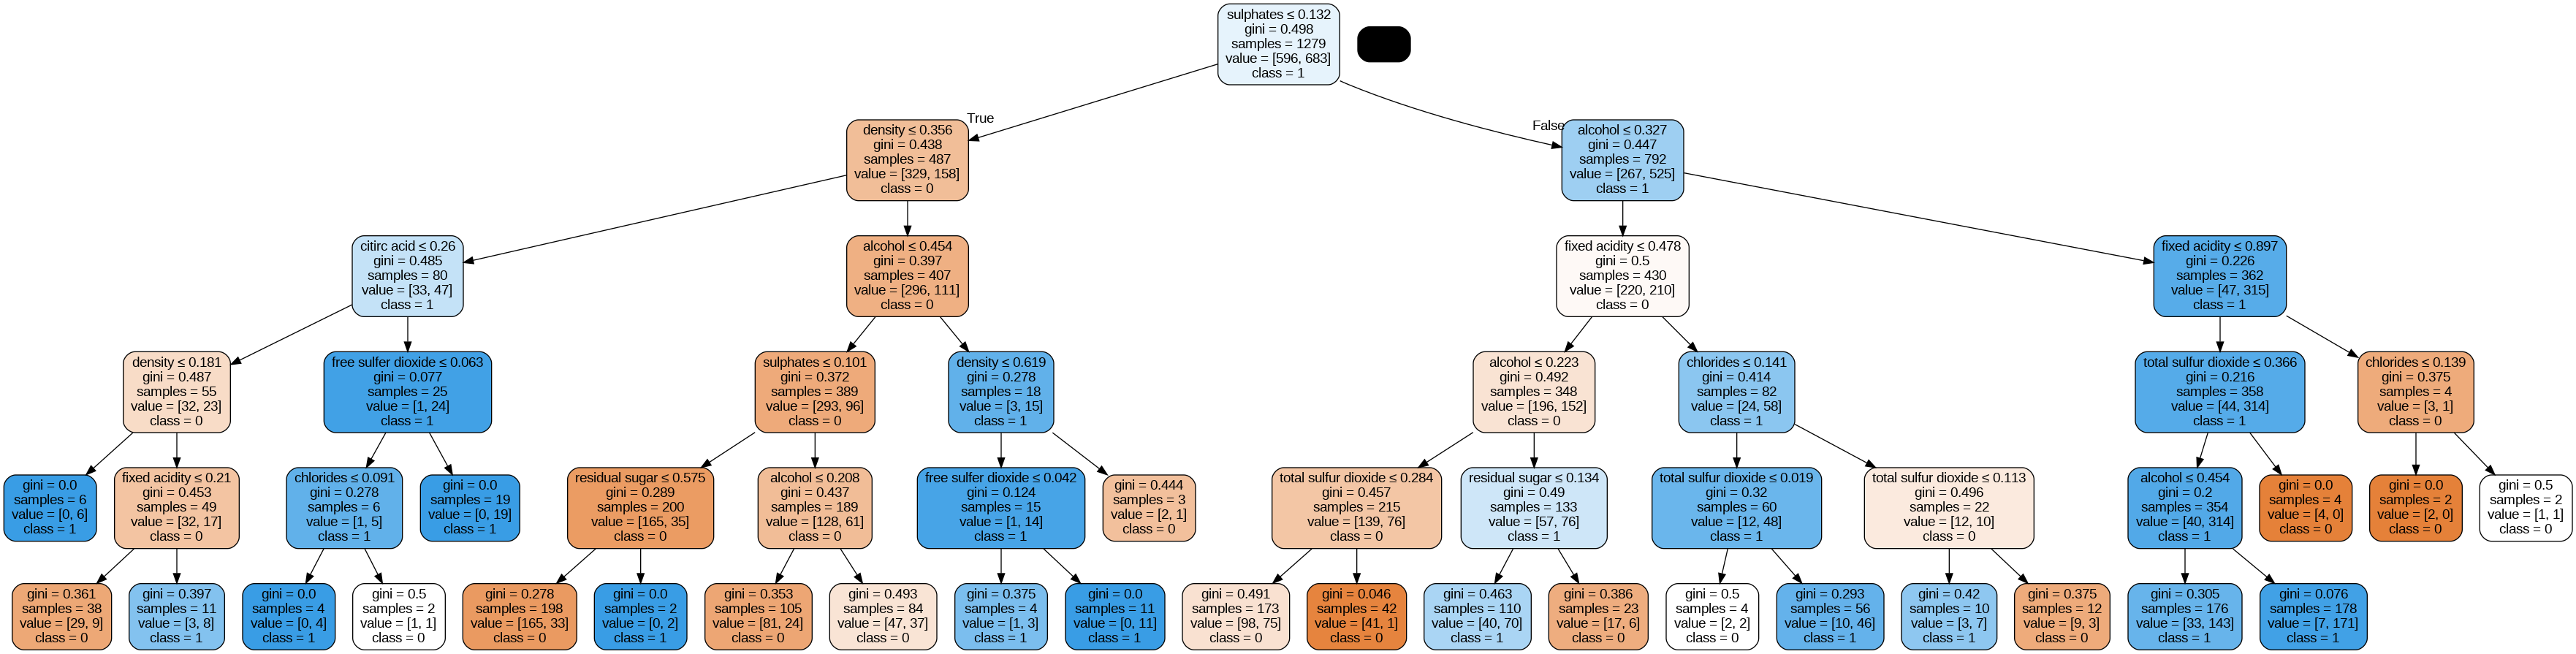

In [ ]:
# Tree Visualization
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=[str(c) for c in y_distinct])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('wine.png')
Image(graph.create_png())

In [ ]:
# Hyperparameter Tuning for RandomForest Classifier
rf = RandomForestClassifier()
params = {'max_depth': range(1,10),
          'n_estimators': [10, 50, 100, 200],
          'max_features': ['sqrt', 'log2', None],
          'min_samples_leaf':[1,2,3],
          }

gs_rf = GridSearchCV(rf, params, scoring='accuracy', cv=5, verbose = 3, n_jobs = -1, return_train_score=False)
gs_rf.fit(X, y)
print(gs_rf.best_params_)
# find best model score
print(gs_rf.score(X, y))

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 50}
0.8030018761726079


In [ ]:
# Create Random Forest Classifer object
rf = RandomForestClassifier(max_depth = 5, max_features = 'sqrt', min_samples_leaf = 3, n_estimators = 50)
# Train Random Forest Classifer
rf = rf.fit(X_train,y_train)
#Predict the response for test dataset
y_pred = rf.predict(X_test)
y_probs = rf.predict_proba(X_test)

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
scores = cross_val_score(rf, X, y, cv=5)
print("Cross Validation Score: ",scores.mean())
print(classification_report(y_test, y_pred))

Accuracy: 0.759375
Cross Validation Score:  0.7360991379310345
              precision    recall  f1-score   support

           0       0.73      0.76      0.74       148
           1       0.78      0.76      0.77       172

    accuracy                           0.76       320
   macro avg       0.76      0.76      0.76       320
weighted avg       0.76      0.76      0.76       320



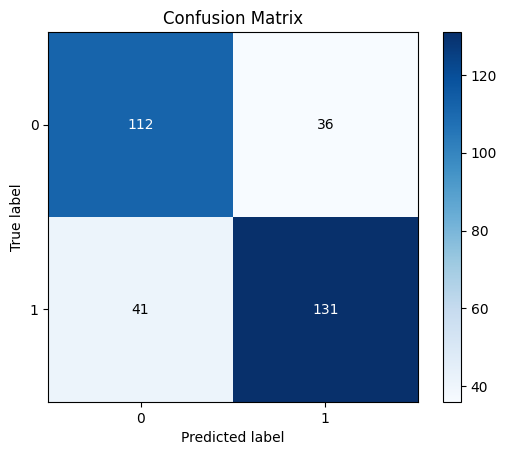

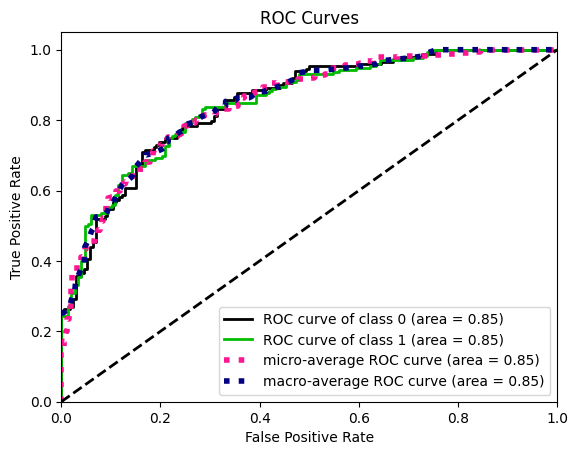

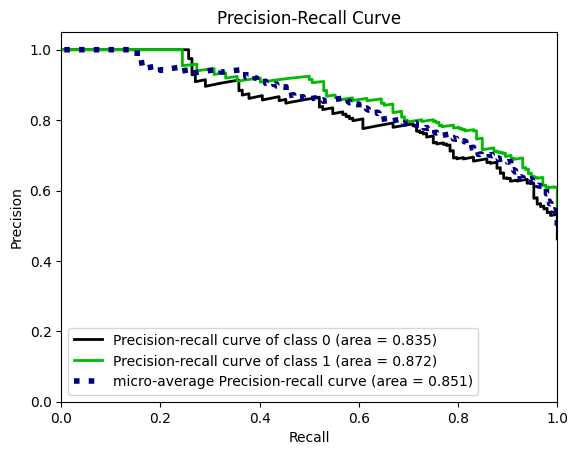

In [ ]:
# Confusion Matrix and graphs of the ROC and Precison-Recall curves
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
skplt.metrics.plot_roc(y_test, y_probs)
skplt.metrics.plot_precision_recall(y_test, y_probs)
plt.show()

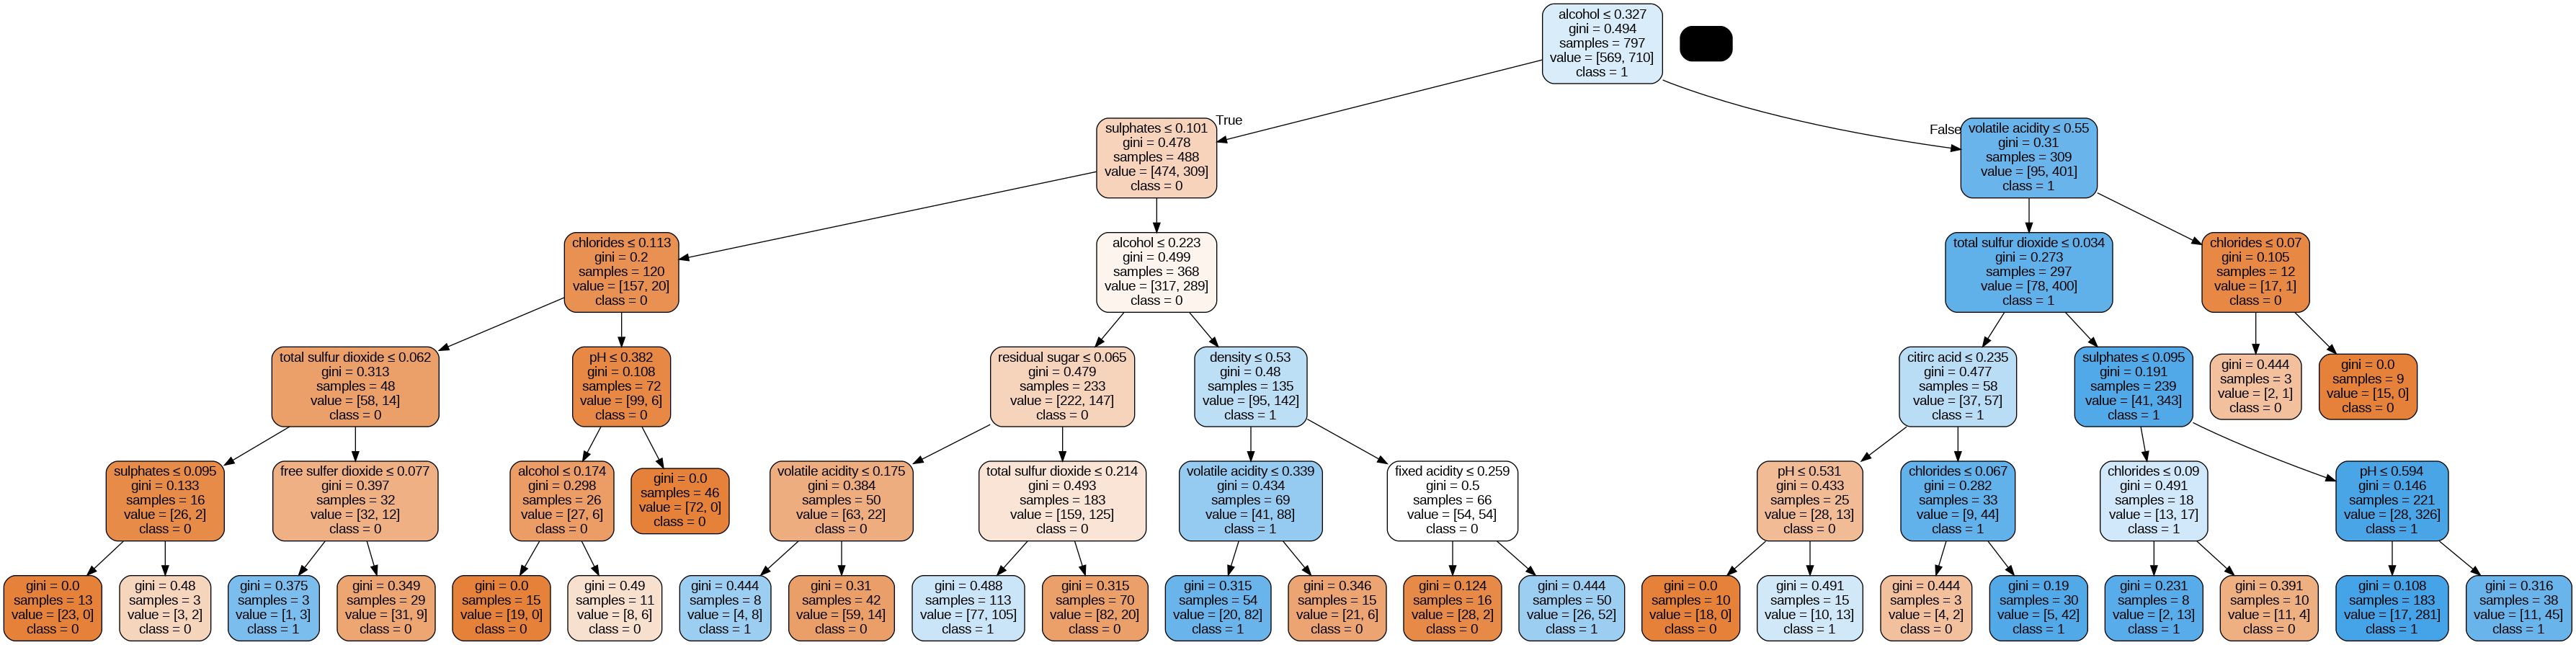

In [ ]:
# Tree Visualization for Random Forest
estimator = rf.estimators_[5]
dot_data = StringIO()
export_graphviz(estimator, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=[str(c) for c in y_distinct])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('wine.png')
Image(graph.create_png())

In [ ]:
# Hyperparameter Tuning for AdaboostClassifier
ada = AdaBoostClassifier()
params = {'n_estimators': [50, 100, 200, 500],
          'learning_rate': [0.1, 0.01, 0.001],
          }

gs_ada = GridSearchCV(ada, params, cv=5, scoring='accuracy', verbose=3, n_jobs=-1)
gs_ada.fit(X, y)
print(gs_ada.best_params_)
# find best model score
print(gs_ada.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'learning_rate': 0.1, 'n_estimators': 100}
0.7435932601880879


In [ ]:
# Create AdaBoostClassifer object
ada = AdaBoostClassifier(learning_rate=0.1, n_estimators=100)
# Train AdaBoostClassifer
ada = ada.fit(X_train,y_train)
# Predict the response for test dataset
y_pred = ada.predict(X_test)
y_probs = ada.predict_proba(X_test)

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
scores = cross_val_score(ada, X, y, cv=5)
print("Cross Validation Score: ",scores.mean())
print(classification_report(y_test, y_pred))

Accuracy: 0.765625
Cross Validation Score:  0.7435932601880879
              precision    recall  f1-score   support

           0       0.74      0.77      0.75       148
           1       0.79      0.76      0.78       172

    accuracy                           0.77       320
   macro avg       0.76      0.77      0.76       320
weighted avg       0.77      0.77      0.77       320



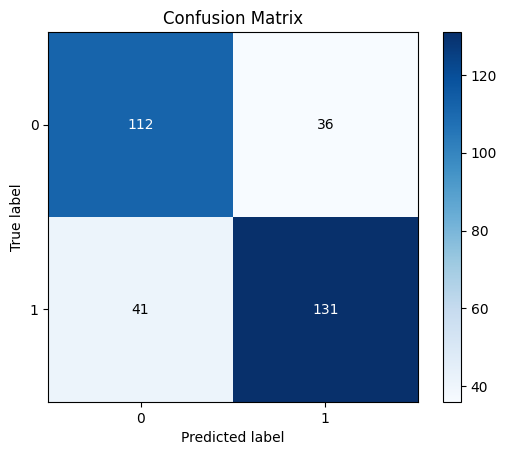

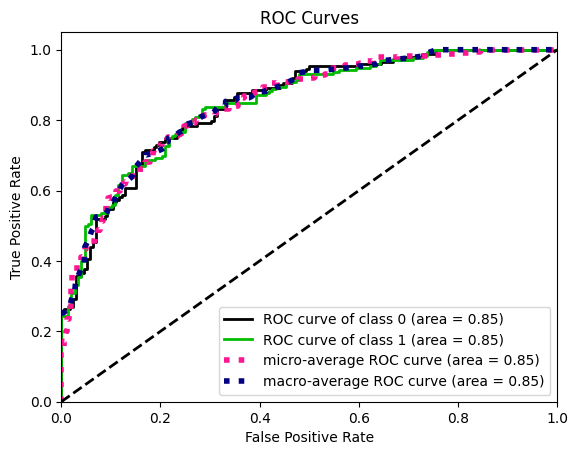

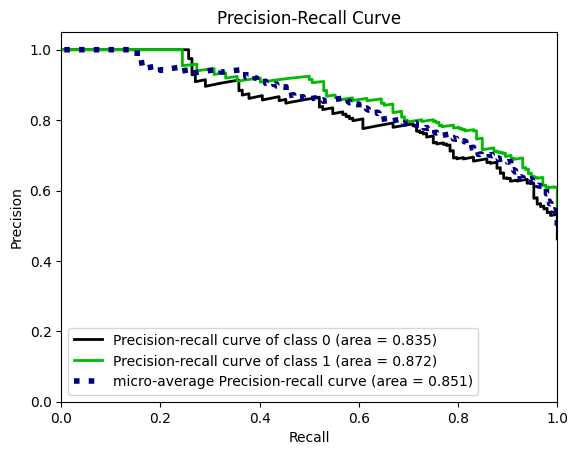

In [ ]:
# Confusion Matrix and graphs of the ROC and Precison-Recall curves
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
skplt.metrics.plot_roc(y_test, y_probs)
skplt.metrics.plot_precision_recall(y_test, y_probs)
plt.show()

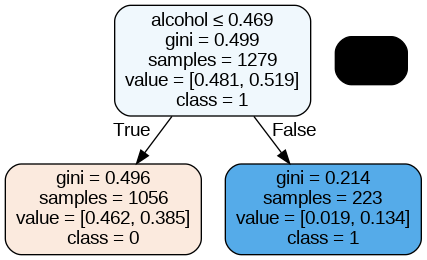

In [ ]:
# Tree Visualization for AdaBoost
estimator = ada.estimators_[5]
dot_data = StringIO()
export_graphviz(estimator, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=[str(c) for c in y_distinct])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('wine.png')
Image(graph.create_png())

In [ ]:
# Hyperparameter Tuning for XGBoostClassifier
xgb = xgboost.XGBClassifier(n_jobs=multiprocessing.cpu_count() // 2)
params = {'max_depth': [2, 4, 6],
          'n_estimators': [50, 100, 200, 500],
          'learning_rate': [0.1, 0.01, 0.001],
          'subsample': [0.5, 0.7, 1]
          }

gs_xgb = GridSearchCV(xgb, params, cv=5, scoring='accuracy', verbose=3, n_jobs=-1)
gs_xgb.fit(X, y)
print(gs_xgb.best_params_)
# find best model score
print(gs_xgb.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 500, 'subsample': 0.7}
0.7442084639498433


In [ ]:
# Create XGBoostClassifer object
xgb = xgboost.XGBClassifier(max_depth=2, n_estimators=500, subsample=0.7, learning_rate=0.01, n_jobs=multiprocessing.cpu_count() // 2)
# Train XGBoostClassifer
xgb = xgb.fit(X_train,y_train)
# Predict the response for test dataset
y_pred = xgb.predict(X_test)
y_probs = xgb.predict_proba(X_test)

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
scores = cross_val_score(xgb, X, y, cv=5)
print("Cross Validation Score: ",scores.mean())
print(classification_report(y_test, y_pred))

Accuracy: 0.75
Cross Validation Score:  0.7442084639498433
              precision    recall  f1-score   support

           0       0.73      0.74      0.73       148
           1       0.77      0.76      0.77       172

    accuracy                           0.75       320
   macro avg       0.75      0.75      0.75       320
weighted avg       0.75      0.75      0.75       320



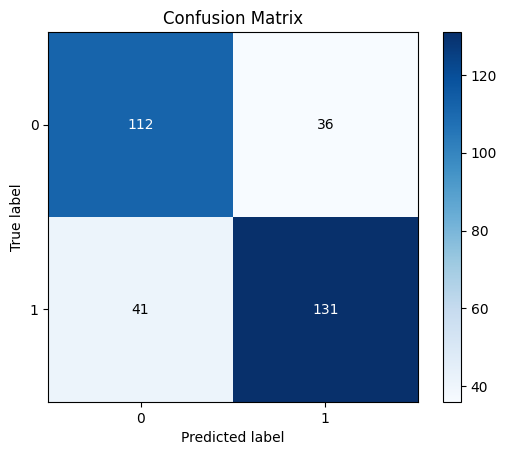

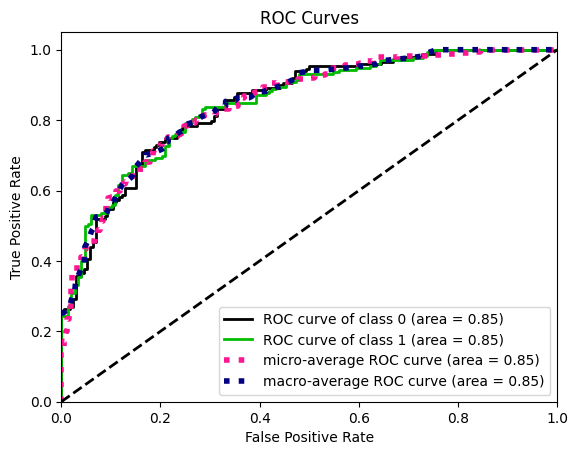

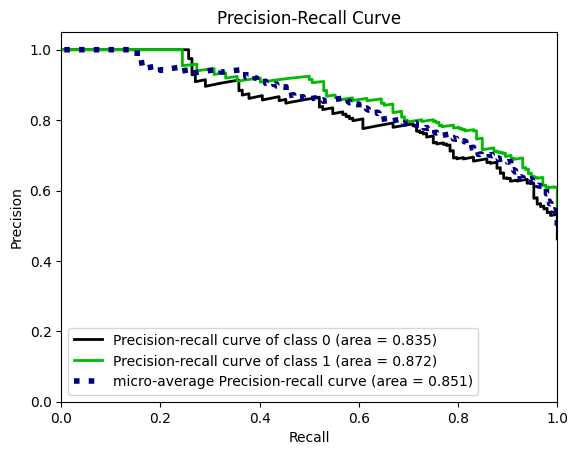

In [ ]:
# Confusion Matrix and graphs of the ROC and Precison-Recall curves
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
skplt.metrics.plot_roc(y_test, y_probs)
skplt.metrics.plot_precision_recall(y_test, y_probs)
plt.show()

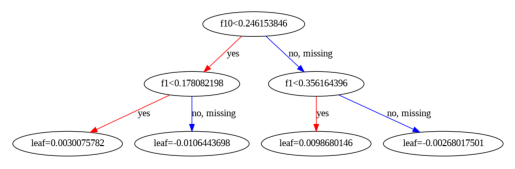

In [ ]:
# Tree Visualization for XGBoost
plot_tree(xgb)
plt.show()